In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras 
import matplotlib.pyplot as plt
import cv2
import glob
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
import os
from keras.layers import BatchNormalization
from tensorflow.keras.mixed_precision import experimental as mixed_precision
import natsort as nt

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from keras.layers import Dense, Dropout, Flatten

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [3]:
# set to run in float16
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2060 SUPER, compute capability 7.5


In [4]:
# load data stored at windows partiton (remember to load the drive)
img_data = np.array([cv2.imread(file,0) for file in nt.natsorted(glob.glob("/media/rifqiaufan/Local Disk/Dataset/img_set/img_set_10/*.jpg"))])
label_data = pd.read_csv('/media/rifqiaufan/Local Disk/Dataset/img_set/label_10_binary.csv', names = ['grade'],header=None)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(img_data, label_data, test_size=0.33, random_state=133)

In [6]:
regularizer = tf.keras.regularizers.l1_l2(l1 = 0,l2=0.1)

In [7]:
# setup network

model = Sequential()

model.add(Conv2D(16,(2,2),
         activation = 'relu', input_shape = (64,64,1),padding = 'same'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32,(2,2),
         activation = 'relu', input_shape = (64,64,1),padding = 'same'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32,(2,2),
         activation = 'relu',padding = 'same'))
model.add(Conv2D(32,(2,2),
         activation = 'relu',padding = 'same'))
model.add(MaxPooling2D((2,2)))

model.add(keras.layers.Flatten())
model.add(Dense(8, activation='relu',kernel_regularizer=regularizer))
model.add(Dropout(.5))
model.add(Dense(2, activation='softmax'))

model.summary()

# ,kernel_regularizer=regularizer

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4128      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        4128      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0

In [9]:
# serialize model/network to JSON and save it into the disk
model_json = model.to_json()
with open("model10_binary_base.json", "w") as json_file:
    json_file.write(model_json)

print("Saved model to disk")

Saved model to disk


In [10]:
## Load trained model for further training

# load saved model
# json_file = open('model10_binary.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# model = model_from_json(loaded_model_json)
# model.summary()

In [11]:
# reshape the data for training and validation

from tensorflow.keras.utils import to_categorical


print (X_train.shape)
print (X_test.shape)
train_images = X_train.reshape((X_train.shape[0], 64, 64, 1))
train_images = train_images.astype('float32') / 255

test_images = X_test.reshape((X_test.shape[0], 64, 64, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

(5788, 64, 64)
(2852, 64, 64)


Epoch 1/200
243/243 [==============================] - ETA: 0s - loss: 1.6336 - accuracy: 0.7212
Epoch 00001: val_accuracy improved from -inf to 0.72318, saving model to best_model10_binary.h5
243/243 [==============================] - 2s 9ms/step - loss: 1.6336 - accuracy: 0.7212 - val_loss: 1.1855 - val_accuracy: 0.7232
Epoch 2/200
237/243 [============================>.] - ETA: 0s - loss: 0.9772 - accuracy: 0.7220
Epoch 00002: val_accuracy did not improve from 0.72318
243/243 [==============================] - 2s 8ms/step - loss: 0.9740 - accuracy: 0.7209 - val_loss: 0.7952 - val_accuracy: 0.7232
Epoch 3/200
236/243 [============================>.] - ETA: 0s - loss: 0.6994 - accuracy: 0.7201
Epoch 00003: val_accuracy did not improve from 0.72318
243/243 [==============================] - 2s 8ms/step - loss: 0.6958 - accuracy: 0.7209 - val_loss: 0.5834 - val_accuracy: 0.7232
Epoch 4/200
237/243 [============================>.] - ETA: 0s - loss: 0.5648 - accuracy: 0.7360
Epoch 00004: 

Epoch 29/200
237/243 [============================>.] - ETA: 0s - loss: 0.4071 - accuracy: 0.7845
Epoch 00029: val_accuracy did not improve from 0.83046
243/243 [==============================] - 2s 8ms/step - loss: 0.4075 - accuracy: 0.7833 - val_loss: 0.3696 - val_accuracy: 0.8153
Epoch 30/200
242/243 [============================>.] - ETA: 0s - loss: 0.4050 - accuracy: 0.7784
Epoch 00030: val_accuracy did not improve from 0.83046
243/243 [==============================] - 2s 8ms/step - loss: 0.4050 - accuracy: 0.7787 - val_loss: 0.3560 - val_accuracy: 0.8231
Epoch 31/200
236/243 [============================>.] - ETA: 0s - loss: 0.4099 - accuracy: 0.7842
Epoch 00031: val_accuracy did not improve from 0.83046
243/243 [==============================] - 2s 8ms/step - loss: 0.4103 - accuracy: 0.7823 - val_loss: 0.3648 - val_accuracy: 0.7473
Epoch 32/200
236/243 [============================>.] - ETA: 0s - loss: 0.4024 - accuracy: 0.7918
Epoch 00032: val_accuracy did not improve from 0.8

Epoch 58/200
237/243 [============================>.] - ETA: 0s - loss: 0.3644 - accuracy: 0.8194
Epoch 00058: val_accuracy did not improve from 0.86185
243/243 [==============================] - 2s 8ms/step - loss: 0.3646 - accuracy: 0.8187 - val_loss: 0.3128 - val_accuracy: 0.8577
Epoch 59/200
239/243 [============================>.] - ETA: 0s - loss: 0.3671 - accuracy: 0.8167
Epoch 00059: val_accuracy did not improve from 0.86185
243/243 [==============================] - 2s 8ms/step - loss: 0.3670 - accuracy: 0.8156 - val_loss: 0.3187 - val_accuracy: 0.8613
Epoch 60/200
237/243 [============================>.] - ETA: 0s - loss: 0.3657 - accuracy: 0.8201
Epoch 00060: val_accuracy did not improve from 0.86185
243/243 [==============================] - 2s 8ms/step - loss: 0.3663 - accuracy: 0.8189 - val_loss: 0.3122 - val_accuracy: 0.8577
Epoch 61/200
242/243 [============================>.] - ETA: 0s - loss: 0.3640 - accuracy: 0.8171
Epoch 00061: val_accuracy improved from 0.86185 to

Epoch 86/200
241/243 [============================>.] - ETA: 0s - loss: 0.3444 - accuracy: 0.8361
Epoch 00086: val_accuracy did not improve from 0.87389
243/243 [==============================] - 2s 8ms/step - loss: 0.3440 - accuracy: 0.8367 - val_loss: 0.2935 - val_accuracy: 0.8639
Epoch 87/200
243/243 [==============================] - ETA: 0s - loss: 0.3416 - accuracy: 0.8339
Epoch 00087: val_accuracy did not improve from 0.87389
243/243 [==============================] - 2s 8ms/step - loss: 0.3416 - accuracy: 0.8339 - val_loss: 0.3350 - val_accuracy: 0.8550
Epoch 88/200
240/243 [============================>.] - ETA: 0s - loss: 0.3467 - accuracy: 0.8320
Epoch 00088: val_accuracy did not improve from 0.87389
243/243 [==============================] - 2s 8ms/step - loss: 0.3465 - accuracy: 0.8316 - val_loss: 0.3162 - val_accuracy: 0.8561
Epoch 89/200
236/243 [============================>.] - ETA: 0s - loss: 0.3474 - accuracy: 0.8300
Epoch 00089: val_accuracy did not improve from 0.8

Epoch 115/200
238/243 [============================>.] - ETA: 0s - loss: 0.3322 - accuracy: 0.8448
Epoch 00115: val_accuracy did not improve from 0.88592
243/243 [==============================] - 2s 8ms/step - loss: 0.3314 - accuracy: 0.8452 - val_loss: 0.2810 - val_accuracy: 0.8823
Epoch 116/200
237/243 [============================>.] - ETA: 0s - loss: 0.3352 - accuracy: 0.8365
Epoch 00116: val_accuracy did not improve from 0.88592
243/243 [==============================] - 2s 8ms/step - loss: 0.3371 - accuracy: 0.8375 - val_loss: 0.2815 - val_accuracy: 0.8849
Epoch 117/200
239/243 [============================>.] - ETA: 0s - loss: 0.3237 - accuracy: 0.8502
Epoch 00117: val_accuracy did not improve from 0.88592
243/243 [==============================] - 2s 8ms/step - loss: 0.3227 - accuracy: 0.8509 - val_loss: 0.2936 - val_accuracy: 0.8791
Epoch 118/200
237/243 [============================>.] - ETA: 0s - loss: 0.3287 - accuracy: 0.8410
Epoch 00118: val_accuracy did not improve from

Epoch 144/200
242/243 [============================>.] - ETA: 0s - loss: 0.3173 - accuracy: 0.8533
Epoch 00144: val_accuracy did not improve from 0.89011
243/243 [==============================] - 2s 8ms/step - loss: 0.3171 - accuracy: 0.8535 - val_loss: 0.2813 - val_accuracy: 0.8718
Epoch 145/200
237/243 [============================>.] - ETA: 0s - loss: 0.3233 - accuracy: 0.8481
Epoch 00145: val_accuracy improved from 0.89011 to 0.89639, saving model to best_model10_binary.h5
243/243 [==============================] - 2s 8ms/step - loss: 0.3232 - accuracy: 0.8486 - val_loss: 0.2596 - val_accuracy: 0.8964
Epoch 146/200
242/243 [============================>.] - ETA: 0s - loss: 0.3285 - accuracy: 0.8438
Epoch 00146: val_accuracy did not improve from 0.89639
243/243 [==============================] - 2s 8ms/step - loss: 0.3285 - accuracy: 0.8437 - val_loss: 0.2953 - val_accuracy: 0.8828
Epoch 147/200
237/243 [============================>.] - ETA: 0s - loss: 0.3257 - accuracy: 0.8539
Ep

Epoch 173/200
241/243 [============================>.] - ETA: 0s - loss: 0.3114 - accuracy: 0.8631
Epoch 00173: val_accuracy did not improve from 0.89639
243/243 [==============================] - 2s 8ms/step - loss: 0.3108 - accuracy: 0.8636 - val_loss: 0.2718 - val_accuracy: 0.8755
Epoch 174/200
241/243 [============================>.] - ETA: 0s - loss: 0.3119 - accuracy: 0.8613
Epoch 00174: val_accuracy improved from 0.89639 to 0.89796, saving model to best_model10_binary.h5
243/243 [==============================] - 2s 8ms/step - loss: 0.3116 - accuracy: 0.8615 - val_loss: 0.2599 - val_accuracy: 0.8980
Epoch 175/200
241/243 [============================>.] - ETA: 0s - loss: 0.3141 - accuracy: 0.8620
Epoch 00175: val_accuracy did not improve from 0.89796
243/243 [==============================] - 2s 8ms/step - loss: 0.3135 - accuracy: 0.8625 - val_loss: 0.3347 - val_accuracy: 0.8629
Epoch 176/200
238/243 [============================>.] - ETA: 0s - loss: 0.3064 - accuracy: 0.8661
Ep

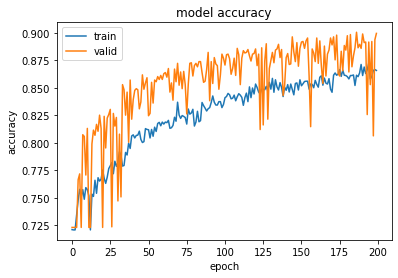

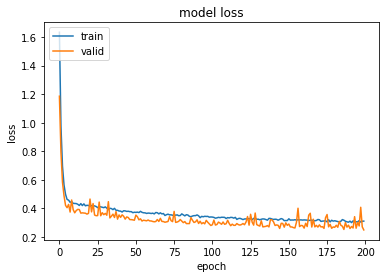

90/90 [==============================] - 0s 3ms/step - loss: 0.2649 - accuracy: 0.8888
Test accuracy: 0.8888499140739441


In [12]:
# hyperparameter setup

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=1000,
    decay_rate=0.9)

# optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)
# optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

es = EarlyStopping(monitor='val_loss', mode='min',verbose=1, patience=200)
mc = ModelCheckpoint('best_model10_binary.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

history = model.fit(train_images, train_labels,
                    validation_split=0.33,
                    batch_size=16,
                    epochs=200,
                    verbose=1,
                    callbacks = [es,mc])


# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

In [13]:
# serialize model/network to JSON and save it into the disk
model_json = model.to_json()
with open("model10_binary.json", "w") as json_file:
    json_file.write(model_json)

print("Saved model to disk")

Saved model to disk


In [14]:
# # load existing json model for statistics
# json_file = open('model10_binary.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# model = model_from_json(loaded_model_json)

# model.load_weights("best_model10_binary.h5")

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [16]:
# predict probabilities for test set
yhat_probs = model.predict(test_images, verbose=0)
# predict crisp classes for test set
yhat_classes = np.argmax(model.predict(test_images, verbose=0), axis=-1)#model.predict_classes(test_images, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
# yhat_classes = yhat_classes[:, 0]
 
test_val = np.array(y_test['grade'])
test_labels_mod = test_labels[:,0]


In [17]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_val, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_val, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_val, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_val, yhat_classes)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(test_val, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(test_labels_mod, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(test_val, yhat_classes)
print(matrix)

Accuracy: 0.888850
Precision: 0.924830
Recall: 0.921701
F1 score: 0.923263
Cohens kappa: 0.721739
ROC AUC: 0.959134
[[ 628  155]
 [ 162 1907]]


In [18]:
tn, fp, fn, tp = confusion_matrix(test_val, yhat_classes).ravel()
(tn, fp, fn, tp)

(628, 155, 162, 1907)

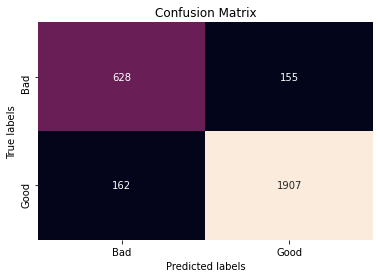

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax,fmt='d', cbar = False); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Bad', 'Good']); ax.yaxis.set_ticklabels(['Bad', 'Good']);

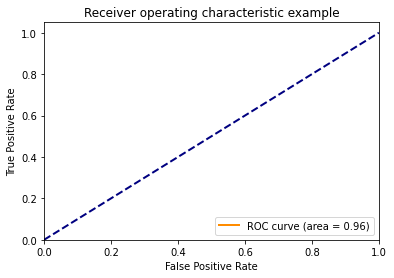

In [20]:
plt.figure()
lw = 2
plt.plot(fp, tp, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [21]:
predictions = model.predict(test_images, verbose=0)
fix_score = y_test['grade']
test_labels_mod = fix_score.values.tolist()
class_names = ['bad','good']

In [22]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img,cmap='gray')

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color,
                                fontsize=80)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks([0,1],['Bad','Good'])
  plt.yticks([])
  thisplot = plt.bar(range(2), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [23]:
# # test outpu classification
# i = 6
# plt.figure(figsize=(6,3))
# plt.subplot(1,2,1)
# plot_image(i, predictions[i], test_labels_mod, test_images)
# plt.subplot(1,2,2)
# plot_value_array(i, predictions[i],  test_labels_mod)
# plt.show()

In [24]:
import matplotlib 
matplotlib.rc('xtick', labelsize=80) 
matplotlib.rc('ytick', labelsize=80) 

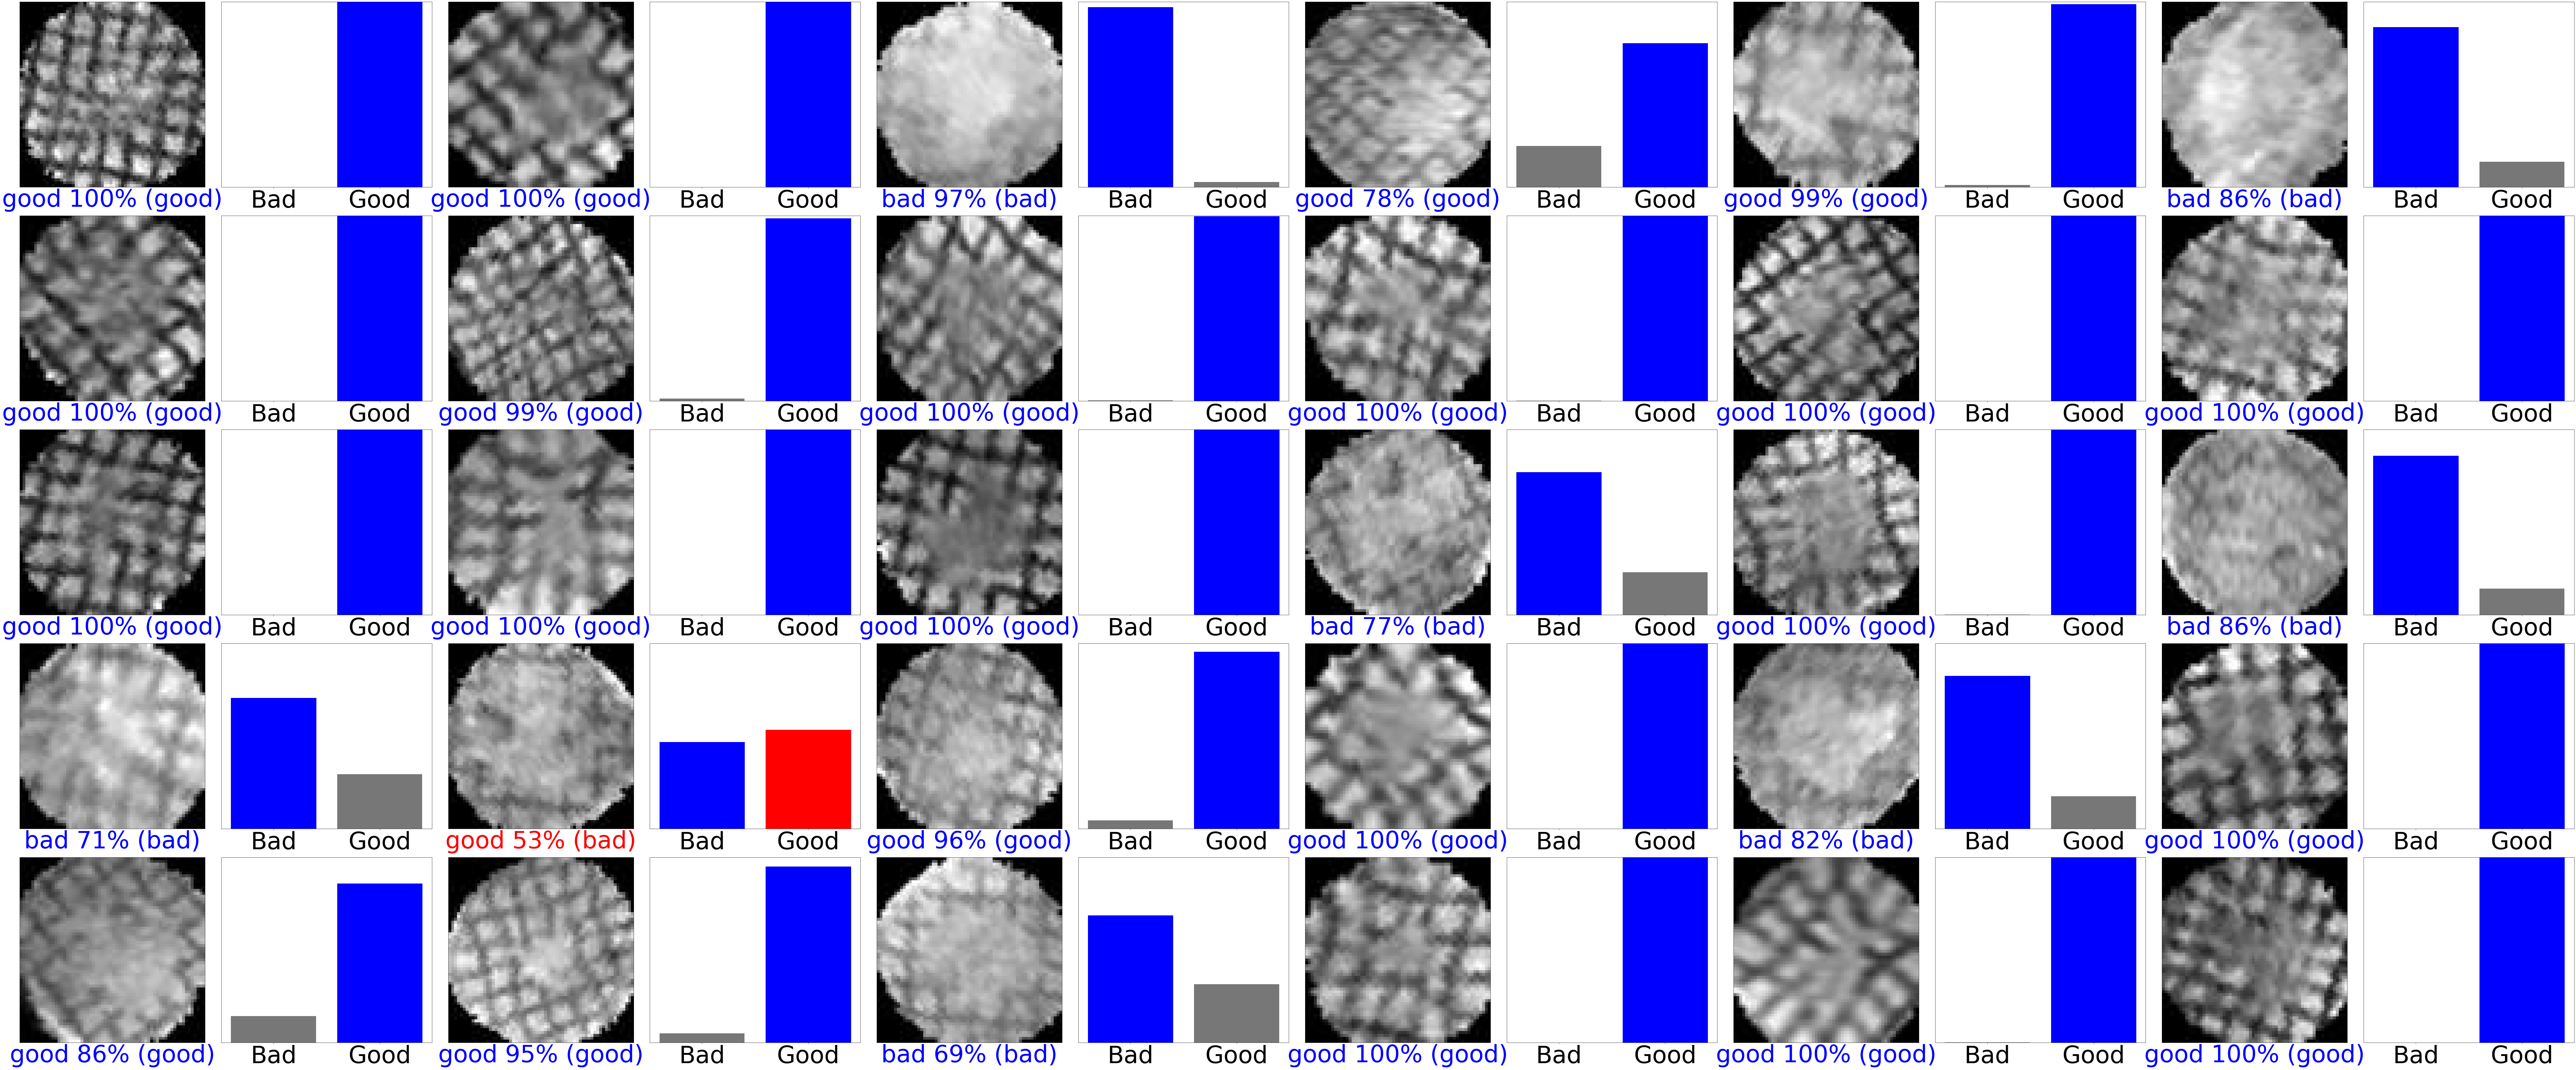

In [25]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.


num_rows = 5
num_cols = 6
num_images = num_rows*num_cols
plt.figure(figsize=(2*10*num_cols, 10*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels_mod, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels_mod)
plt.tight_layout()
plt.show()